建立基础回测框架

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import backtrader as bt
import pandas as pd
from self_package import get_stock
from self_package import tech_index as ti
# 设置全局风格
plt.style.use('ggplot')  # 或者尝试 'seaborn', 'fivethirtyeight', 'bmh' 等
import mpld3
import PIL

In [2]:
df_ts = get_stock.get_stock_data("601111", "daily", "20250107", "20250407")
df_ts = get_stock.standardize_stock_data(df_ts)
df_ts_version = get_stock.create_backtrader_data(df_ts)


In [3]:
# 定义策略
class SMAStrategy(bt.Strategy):

    def __init__(self):
        self.dataclose = self.data0.close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        self.sma = bt.indicators.SimpleMovingAverage(self.data0, period=15)
    
    def next(self):
        if not self.position:
            if self.dataclose[0] > self.sma[0]:
                self.buy()
        else:
            if self.dataclose[0] < self.sma[0]:
                self.close()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, 
                     order.executed.value, 
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log("SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f" %
                    (order.executed.price, 
                     order.executed.value, 
                     order.executed.comm))
                self.bar_executed = len(self)
        elif order.status in [order.Margin, order.Rejected]:
            self.log("Order failed")
        self.order = None

    def log(self, txt, dt=None,doprint=True):
        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

注意 持续保持后端是inline 否则就会没有图片

In [4]:
# 在代码最开始添加这些行
import matplotlib
print("当前后端:", matplotlib.get_backend())


当前后端: inline


2025-02-25, BUY EXECUTED, Price: 7.05, Cost: 2983.07, Comm 1.79
2025-03-14, SELL EXECUTED, Price: 7.20, Cost: 2983.07, Comm 1.83
2025-03-17, BUY EXECUTED, Price: 7.41, Cost: 3042.59, Comm 1.83
2025-03-21, SELL EXECUTED, Price: 7.33, Cost: 3042.59, Comm 1.81
2025-03-26, BUY EXECUTED, Price: 7.60, Cost: 2999.12, Comm 1.80
2025-03-31, SELL EXECUTED, Price: 7.28, Cost: 2999.12, Comm 1.72
夏普比率分析结果: None
最大回撤分析结果: 2.9361792880556696


<IPython.core.display.Javascript object>

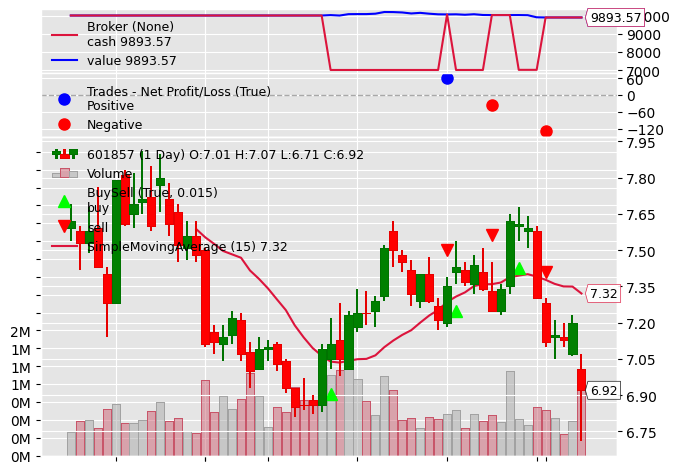

In [5]:
# from backtrader_plotting import Bokeh
# from backtrader_plotting.schemes import Tradimo

if __name__ == "__main__":
    cerebro = bt.Cerebro()

    # 读取数据
    stock_value = df_ts_version
    
    # 读取数据
    cerebro.adddata(stock_value, name="601857")
    
    # 读取策略
    cerebro.addstrategy(SMAStrategy)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name = "drawdown")

    # 设置初始资金
    cerebro.broker.setcash(10000)
    # 设置佣金
    cerebro.broker.setcommission(commission=0.0006)
    # 设置购买比例
    cerebro.addsizer(bt.sizers.PercentSizer, percents=30)

    result = cerebro.run()
    
    print("夏普比率分析结果:", result[0].analyzers.sharpe.get_analysis()['sharperatio'])
    print("最大回撤分析结果:", result[0].analyzers.drawdown.get_analysis()['drawdown'])

    import matplotlib.pyplot as plt
    plt.rcParams.update({'text.color': 'black',
                        'axes.labelcolor': 'black',
                        'xtick.color': 'black',
                        'ytick.color': 'black'})

    # 4. 完整图表（可选）
    figs_full = cerebro.plot(style='candle', barup='green', bardown='red', volume=True)
    plt.savefig('full_chart.png')
    
    matplotlib.use('inline')
    plt.show()
